In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from tqdm import tqdm
from itertools import product
import matplotlib.colors as colors
#import matplotlib.cm as cm

#import networkx as nx

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import geopandas as gpd
from shapely.geometry import Point
import pyproj
#pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer
import folium

### Load data

In [2]:
#source = '/mnt/raw_data/'
source = '/media/Data_storage/Mobilcell/Data/'

In [3]:
files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events_cleaned = np.array( sorted([ i for i in os.listdir(source) if 'Events' in i]) )
files_events_cleaned.shape, files_events.shape, files_poligons.shape

((365,), (365,), (365,))

### Investigate polygons file

In [4]:
source+files_poligons[100], source+files_events[100]

('/media/Data_storage/Mobilcell/Data/MT_MTA_NETWORK_POLIGONS_20190311.csv.gz',
 '/media/Data_storage/Mobilcell/Data/MT_MTA_NETWORK_EVENTS_20190311.csv.gz')

In [5]:
poligons_df = pd.read_csv( source+files_poligons[100], delimiter=';' )
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type
0,10071347,216918,496318,127,127,D
1,10071347,216918,496445,127,127,D
2,10071347,217045,496191,127,127,D
3,10071347,217045,496318,127,127,D
4,10071347,217045,496572,127,127,D


In [6]:
poligons_df.tail()

,network_identifier,eovx,eovy,dx,dy,network_element_type
26053295,99591498,195455,562739,127,127,D
26053296,99591498,195455,562866,127,127,D
26053297,99591498,195455,562993,127,127,D
26053298,99591498,195582,562739,127,127,D
26053299,99591498,195709,562612,127,127,D


In [7]:
poligons_df.shape

(26053300, 6)

In [8]:
net_elem_types =  np.unique( poligons_df.network_element_type )
net_elem_types

array(['A', 'B', 'C', 'D', 'E', 'U'], dtype=object)

In [9]:
np.unique( poligons_df.network_identifier ).shape

(43155,)

#### Choose a specific tower

In [10]:
poligons_df[ (poligons_df.network_identifier.values == 72922) ]

,network_identifier,eovx,eovy,dx,dy,network_element_type
23226044,72922,241429,549658,127,127,B
23226045,72922,241683,548515,127,127,B
23226046,72922,241810,548515,127,127,B
23226047,72922,241810,548642,127,127,B
23226048,72922,241810,549277,127,127,B
...,...,...,...,...,...,...
23227972,72922,253240,550928,127,127,B
23227973,72922,253367,548134,127,127,B
23227974,72922,253367,548261,127,127,B
23227975,72922,253367,550801,127,127,B


#### Coordinate system transformation, checking boundaries

In [11]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
crs_eov, crs_lonlat

(<Projected CRS: EPSG:23700>
 Name: HD72 / EOV
 Axis Info [cartesian]:
 - Y[east]: Easting (metre)
 - X[north]: Northing (metre)
 Area of Use:
 - name: Hungary
 - bounds: (16.11, 45.74, 22.9, 48.58)
 Coordinate Operation:
 - name: Egyseges Orszagos Vetuleti
 - method: Hotine Oblique Mercator (variant B)
 Datum: Hungarian Datum 1972
 - Ellipsoid: GRS 1967
 - Prime Meridian: Greenwich, <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

Center coordinates
- 684692.78 201865.84

Projected bounds:
- 421391.21 48212.58
- 934220.63 366660.88

WGS84 bounds:
- 16.11 45.74
- 22.9 48.58

These values define the official bounding box:
- eov_bottom_left_x = uint32(48210)
- eov_bottom_left_y = uint32(421391)
- eov_top_right_x   = uint32(366660)
- eov_top_right_y   = uint32(934219)

However, these values are based on the bounding box defined by the actual coordinate values found in the polygon files. Some rasters just fall outside the real eov system.
- eov_bottom_left_x = uint32(43944)  // Southern edge.
- eov_bottom_left_y = uint32(426341) // Western edge.
- eov_top_right_x   = uint32(362968) // Northern edge.
- eov_top_right_y   = uint32(937262) // Eastern edge.

#### Need to swap axis! do not forget in order to avoid bad results!

In [12]:
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

In [13]:
transformer.transform(421391, 48210), transformer.transform(934219, 366660)

((45.7399823741122, 16.109994091766758),
 (48.579986767201994, 22.8999816448441))

#### Check other transform tool, too

In [14]:
poligons_df.eovx.values.min(), poligons_df.eovx.values.max()

(43944, 362968)

In [15]:
poligons_df.eovy.values.min(), poligons_df.eovy.values.max()

(426341, 937262)

Text(0, 0.5, 'Frequency')

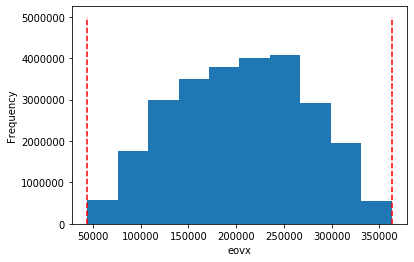

In [16]:
plt.hist( poligons_df.eovx.values )
plt.vlines( 43944, 0, 5e6, color='r', linestyles='--' )
plt.vlines( 362968, 0, 5e6, color='r', linestyles='--' )
plt.xlabel('eovx')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

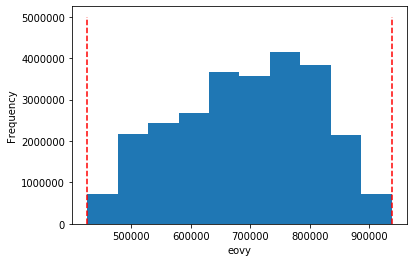

In [17]:
plt.hist( poligons_df.eovy.values )
plt.vlines( 426341, 0, 5e6, color='r', linestyles='--' )
plt.vlines( 937262, 0, 5e6, color='r', linestyles='--' )
plt.xlabel('eovy')
plt.ylabel('Frequency')

#### Conclusion: some fall outside of the official boundaries!

### Leave out that fall outside

In [18]:
poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, poligons_df.eovx.values > 48210 ) ]
poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, poligons_df.eovy.values > 426341 ) ]
poligons_df.shape

(26042098, 6)

In [19]:
tower_df = poligons_df[ (poligons_df.network_identifier.values == 72922) ]
tower_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type
23226044,72922,241429,549658,127,127,B
23226045,72922,241683,548515,127,127,B
23226046,72922,241810,548515,127,127,B
23226047,72922,241810,548642,127,127,B
23226048,72922,241810,549277,127,127,B


### Transorm between systems

In [20]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

#### Check transform: https://epsg.io/transform#s_srs=23700&t_srs=4326&x=216918.0000000&y=496318.0000000

In [21]:
transformer.transform(216918, 496318), transformer.transform(216918, 496318)

((49.658589740094556, 13.04892653270665),
 (49.658589740094556, 13.04892653270665))

In [22]:
X = poligons_df[ (poligons_df.network_identifier.values == 10071347) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 10071347) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

(5252,) (5252,)


(49.51320884858095, 49.741843664360594, 13.048791749895779, 13.356229614114724)

### Visualization of rasters that belongs to a tower

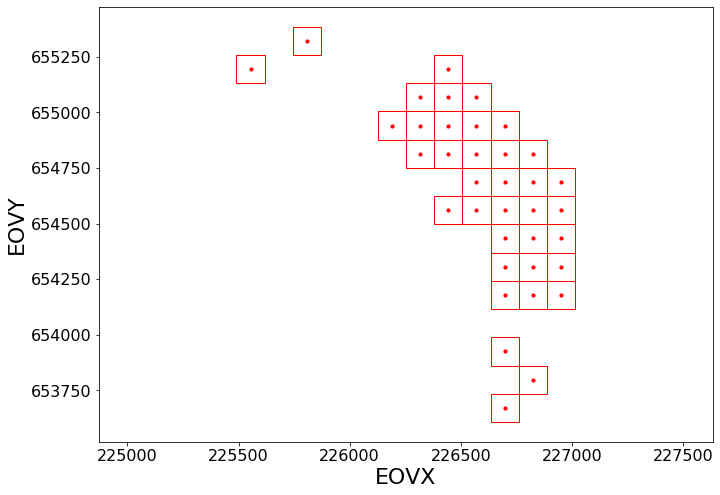

In [58]:
fig = plt.figure( figsize=(11,8) )
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

plt.ylabel('EOVY', fontsize=22)
plt.xlabel('EOVX', fontsize=22)
plt.tick_params( labelsize=16 )
plt.savefig('Lefedettségi_terület_példa_1.png', dpi=100)

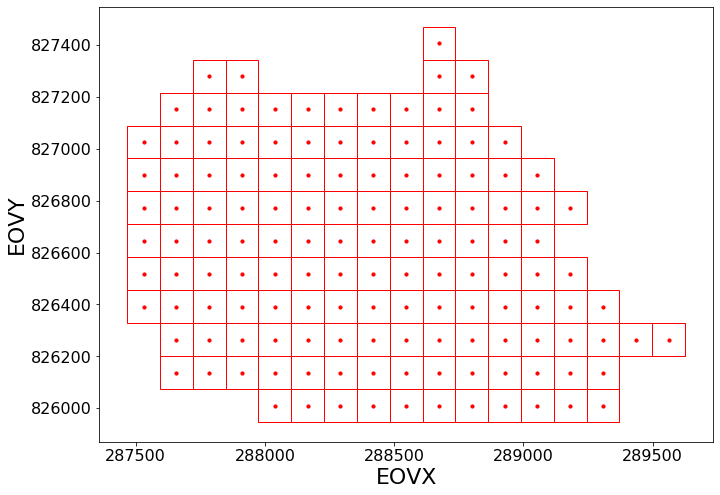

In [59]:
X = poligons_df[ (poligons_df.network_identifier.values == 553841622) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 553841622) ].eovy.values

fig = plt.figure( figsize=(11,8) )
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

plt.ylabel('EOVY', fontsize=22)
plt.xlabel('EOVX', fontsize=22)
plt.tick_params( labelsize=16 )
plt.savefig('Lefedettségi_terület_példa_2.png', dpi=100)

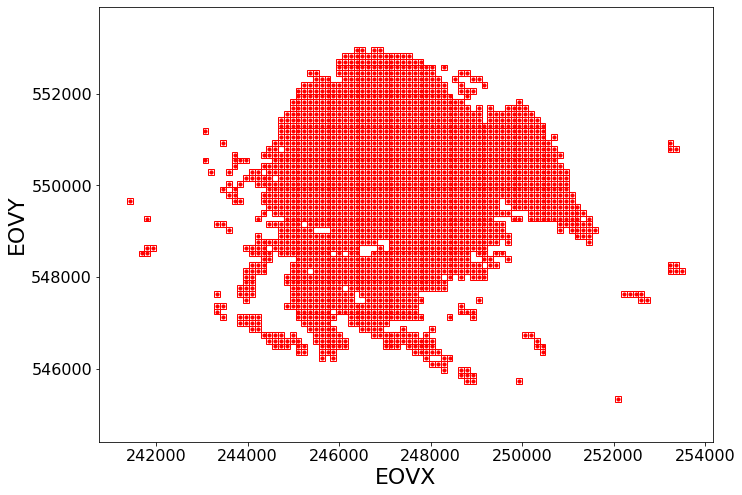

In [60]:
X = poligons_df[ (poligons_df.network_identifier.values == 72922) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 72922) ].eovy.values

fig = plt.figure( figsize=(11,8) )
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

plt.ylabel('EOVY', fontsize=22)
plt.xlabel('EOVX', fontsize=22)
plt.tick_params( labelsize=16 )
plt.savefig('Lefedettségi_terület_példa_3.png', dpi=100)

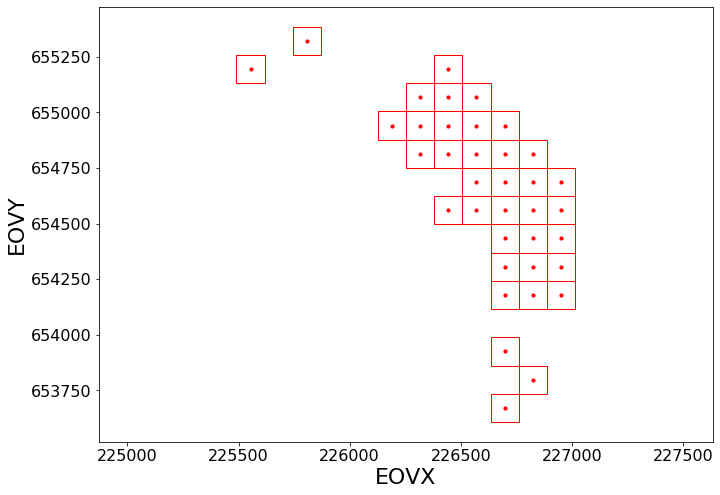

In [61]:
X = poligons_df[ (poligons_df.network_identifier.values == 229021) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 229021) ].eovy.values

fig = plt.figure( figsize=(11,8) )
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

plt.ylabel('EOVY', fontsize=22)
plt.xlabel('EOVX', fontsize=22)
plt.tick_params( labelsize=16 )
plt.savefig('Lefedettségi_terület_példa_4.png', dpi=100)

(96,) (96,)
(702,) (702,)


(257526.25, 270797.75, 538482.0, 545467.0)

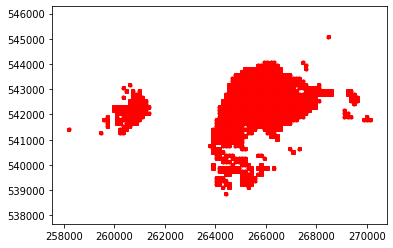

In [27]:
X = poligons_df[ (poligons_df.network_identifier.values == 132968198) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 132968198) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

X = poligons_df[ (poligons_df.network_identifier.values == 30211390) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 30211390) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

#### Lets see what are the typical numbers of rasters that belongs to a tower

In [28]:
net_elem_types

array(['A', 'B', 'C', 'D', 'E', 'U'], dtype=object)

In [29]:
net_elem_dict = dict( zip(net_elem_types[:-1], ['2G', '3G', '4G', '5G'],) ) 
net_elem_dict

{'A': '2G', 'B': '3G', 'C': '4G', 'D': '5G'}

3585604


Text(0.5, 0, 'Number of rasters')

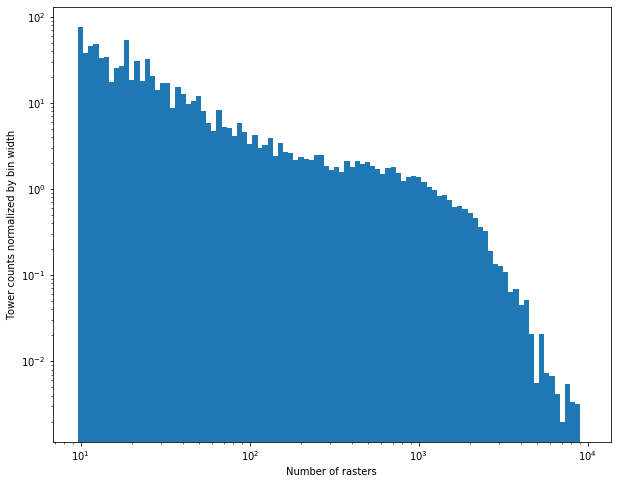

In [30]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(1, 4, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
print( np.sum(poligons_df.network_element_type.values == 'A') )
hist = np.histogram(poligons_df[ poligons_df.network_element_type.values == 'A' ].groupby( by='network_identifier' ).count().network_element_type.values, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts normalized by bin width')
plt.xlabel('Number of rasters')

5738439


Text(0.5, 0, 'Number of rasters')

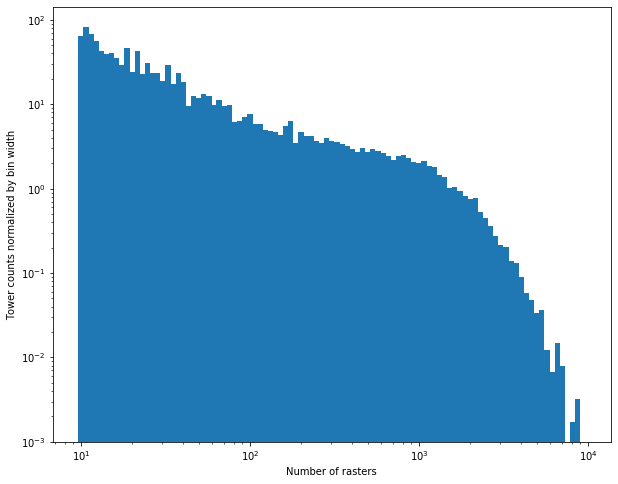

In [31]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(1, 4, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
print( np.sum(poligons_df.network_element_type.values == 'B') )
hist = np.histogram(poligons_df[ poligons_df.network_element_type.values == 'B' ].groupby( by='network_identifier' ).count().network_element_type.values, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts normalized by bin width')
plt.xlabel('Number of rasters')

5490849


Text(0.5, 0, 'Number of rasters')

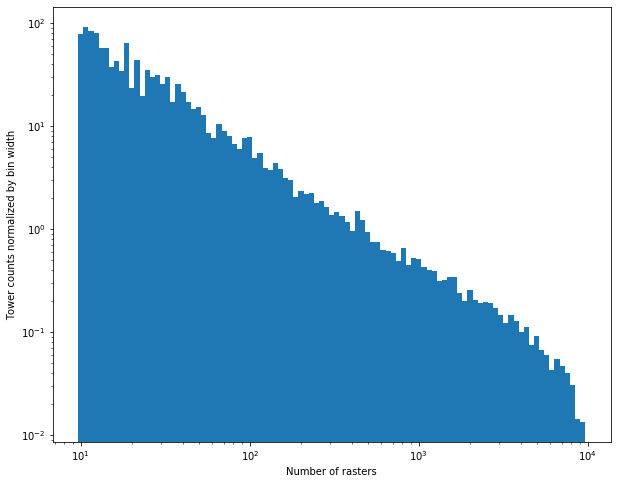

In [32]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(1, 4, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
print( np.sum(poligons_df.network_element_type.values == 'C') )
hist = np.histogram(poligons_df[ poligons_df.network_element_type.values == 'C' ].groupby( by='network_identifier' ).count().network_element_type.values, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts normalized by bin width')
plt.xlabel('Number of rasters')

10909002


Text(0.5, 0, 'Number of rasters')

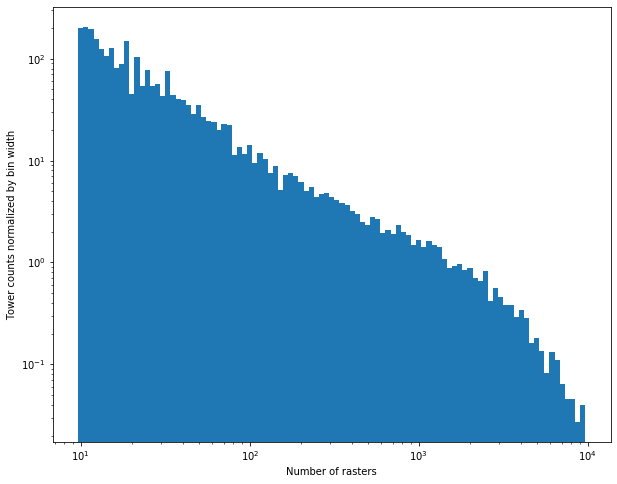

In [33]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(1, 4, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
print( np.sum(poligons_df.network_element_type.values == 'D') )
hist = np.histogram(poligons_df[ poligons_df.network_element_type.values == 'D' ].groupby( by='network_identifier' ).count().network_element_type.values, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts normalized by bin width')
plt.xlabel('Number of rasters')

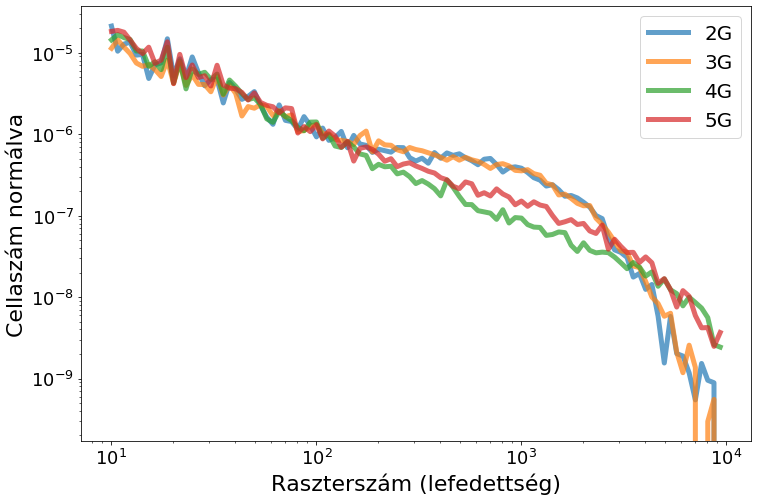

In [34]:
plt.figure( figsize=(12,8) )
bins = np.logspace(1, 4, 100)
widths = (bins[1:] - bins[:-1])

for i in net_elem_types[:4]:
    # Calculate histogram
    hist = np.histogram(poligons_df[ poligons_df.network_element_type.values == i ].groupby( by='network_identifier' ).count().network_element_type.values, bins=bins)
    # normalize by bin width
    hist_norm = hist[0]/widths / np.sum(poligons_df.network_element_type.values == i)
    # plot it!
    #plt.bar(bins[:-1], hist_norm, 0.8*widths, alpha=0.25, label=net_elem_dict[i])
    plt.plot( bins[:-1], hist_norm, label=net_elem_dict[i], linewidth=5, alpha=0.7 )


plt.xscale('log')
plt.yscale('log')
plt.ylabel('Cellaszám normálva', fontsize=22)
plt.xlabel('Raszterszám (lefedettség)', fontsize=22)
plt.tick_params( labelsize=18 )
plt.legend( fontsize=20 )
plt.savefig('Cellatípusok_lefedettségi_területe.png', dpi=100)

Text(0.5, 0, 'Number of rasters')

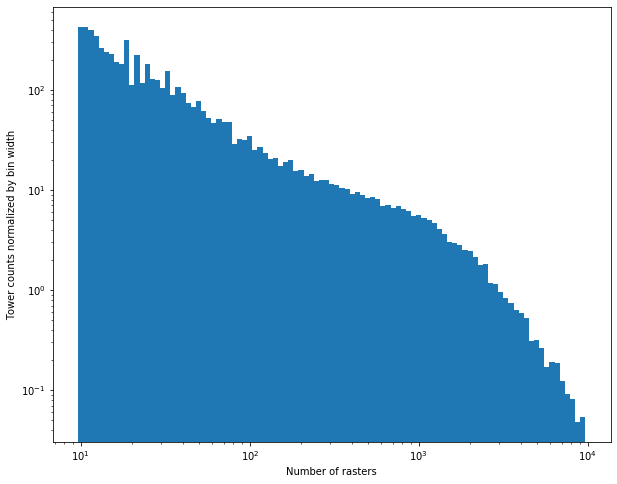

In [35]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(1, 4, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(poligons_df.groupby( by='network_identifier' ).count().network_element_type.values, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts normalized by bin width')
plt.xlabel('Number of rasters')

#### Average number of rasters associated with one tower

In [36]:
 poligons_df.groupby( by='network_identifier' ).count().network_element_type.values.mean()

603.566829675296

#### Calculated average boxside would be

In [37]:
np.sqrt(603*127*127)

3118.6194060834036

Text(0.5, 0, 'Area of a tower [$m^2$]')

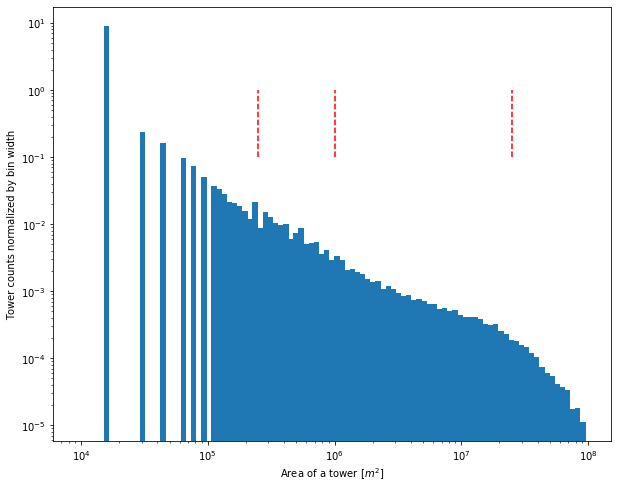

In [38]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(4, 8, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram((poligons_df.groupby( by='network_identifier' ).count().network_element_type.values)*127*127, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.vlines( 500*500, 1e-1, 1e0, color='red', linestyles='--' )
plt.vlines( 1000*1000, 1e-1, 1e0, color='red', linestyles='--' )
plt.vlines( 5000*5000, 1e-1, 1e0, color='red', linestyles='--' )
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts normalized by bin width')
plt.xlabel('Area of a tower [$m^2$]')

#### The marked vertical lines are denoting the area of a box in case of
- 500 m boxside
- 1000 m boxside
- 5000 m boxside

### Create coordinate system

In [39]:
poligons_df.eovx.values.min(), poligons_df.eovx.values.max()

(48262, 362968)

In [40]:
poligons_df.eovy.values.min(), poligons_df.eovy.values.max()

(426468, 934214)

In [41]:
(362968-48262)/127, (934214-426468)/127

(2478.0, 3998.0)

In [42]:
2500*4000 / 1e6

10.0

#### Lets define a coordinate system of the small rasters

In [43]:
start_x = poligons_df.eovx.values.min()
start_y = poligons_df.eovy.values.min()
end_x = poligons_df.eovx.values.max()
end_y = poligons_df.eovy.values.max()
num_x = int( ( end_x - start_x ) / 127 )
num_y = int( ( end_y - start_y ) / 127 )
raster_x = np.arange(start_x, end_x+127, 127, dtype=np.int32)
raster_y = np.arange(start_y, end_y+127, 127, dtype=np.int32)
raster_x.shape, raster_y.shape # shapes should be one more than num!

((2479,), (3999,))

##### All coordinates

In [44]:
raster_coords = np.array( list(product( raster_x, raster_y )) )
raster_coords[:3], raster_coords.shape

(array([[ 48262, 426468],
        [ 48262, 426595],
        [ 48262, 426722]], dtype=int32), (9913521, 2))

##### Building blocks of the coordinates, structure revealed, no need to search for values in df

In [45]:
raster_coords[:,0].reshape( -1, (num_y+1) )[:3] # indexing: i * cols + j

array([[48262, 48262, 48262, ..., 48262, 48262, 48262],
       [48389, 48389, 48389, ..., 48389, 48389, 48389],
       [48516, 48516, 48516, ..., 48516, 48516, 48516]], dtype=int32)

In [46]:
poligons_df.loc[0]

network_identifier      10071347
eovx                      216918
eovy                      496318
dx                           127
dy                           127
network_element_type           D
Name: 0, dtype: object

In [47]:
raster_coords[ int((poligons_df.eovx[0] - start_x) / 127)*(num_y+1) + \
               int((poligons_df.eovy[0] - start_y) / 127) ]

array([216918, 496318], dtype=int32)

#### Extend poligons dataframe 

In [48]:
poligons_df['eovx_num'] = ( (poligons_df.eovx - start_x) / 127 ).astype(int)
poligons_df['eovy_num'] = ( (poligons_df.eovy - start_y) / 127 ).astype(int)
poligons_df['eov_idx'] = poligons_df.eovx_num * (num_y+1) + poligons_df.eovy_num
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx
0,10071347,216918,496318,127,127,D,1328,550,5311222
1,10071347,216918,496445,127,127,D,1328,551,5311223
2,10071347,217045,496191,127,127,D,1329,549,5315220
3,10071347,217045,496318,127,127,D,1329,550,5315221
4,10071347,217045,496572,127,127,D,1329,552,5315223


In [49]:
tower_id = np.unique( poligons_df.network_identifier.values )
tower_id[:5], tower_id.shape

(array([ 71892,  72307,  72922,  73325, 140903]), (43147,))

In [50]:
uniq, counts = np.unique(poligons_df.eov_idx, return_counts=True)

In [51]:
counts.min(), counts.max(), counts.sum(), poligons_df.shape[0]

(1, 107, 26042098, 26042098)

### How many overlaps occur

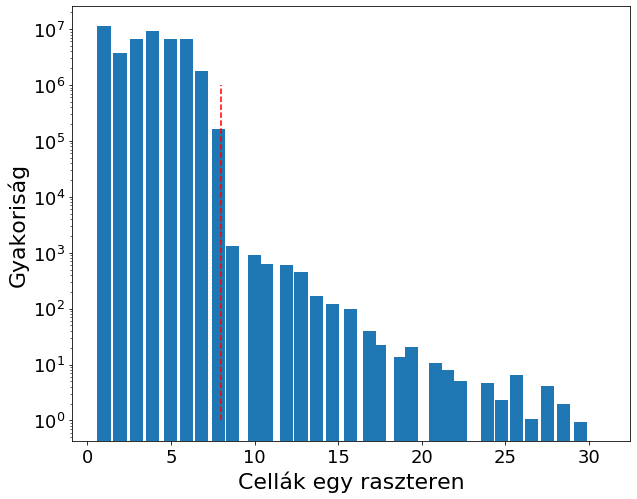

In [53]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(0, 1.5, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram( counts, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm,)# widths)
plt.vlines(8, 1e0, 1e6, color='r', linestyles='--')
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Gyakoriság', fontsize=22)
plt.xlabel('Cellák egy raszteren', fontsize=22)
plt.tick_params( labelsize=18 )
plt.savefig('Átfedő_raszterek_száma.png', dpi=100)

#### Typically there are 1-8 overlaps 

### Investigate events

In [64]:
source+files_events[100]

'/media/Data_storage/Mobilcell/Data/MT_MTA_NETWORK_EVENTS_20190311.csv.gz'

In [65]:
events_df = pd.read_csv( source+files_events[100], delimiter=';' )
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac
0,929,5C800002,22314009,V,O,216,35177706.0
1,934,5C800002,22314009,V,O,216,35177706.0
2,1142,5C800002,22314009,V,O,216,35177706.0
3,1147,5C800002,22314009,V,O,216,35177706.0
4,158,5C800003,325471968,D,O,216,35337609.0


In [66]:
np.unique(events_df.event_type)

array(['D', 'S', 'V'], dtype=object)

In [67]:
events_df.shape[0]/1e6

150.130928

#### Add integer coded towers to dataframes

In [68]:
tower_to_int = dict(zip( tower_id, np.arange(tower_id.shape[0]) ))

In [69]:
poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx,tower_idx
0,10071347,216918,496318,127,127,D,1328,550,5311222,9069
1,10071347,216918,496445,127,127,D,1328,551,5311223,9069
2,10071347,217045,496191,127,127,D,1329,549,5315220,9069
3,10071347,217045,496318,127,127,D,1329,550,5315221,9069
4,10071347,217045,496572,127,127,D,1329,552,5315223,9069


In [70]:
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx
0,929,5C800002,22314009,V,O,216,35177706.0,10651
1,934,5C800002,22314009,V,O,216,35177706.0,10651
2,1142,5C800002,22314009,V,O,216,35177706.0,10651
3,1147,5C800002,22314009,V,O,216,35177706.0,10651
4,158,5C800003,325471968,D,O,216,35337609.0,39888


#### Sort polygons df in order to use a much quicker searching method (gain 1000x speed!)

In [71]:
poligons_df.sort_values( by='tower_idx', inplace=True )

In [72]:
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx,tower_idx
23099845,71892,256034,557659,127,127,B,1636,1033,6543397,0
23098519,71892,251208,560834,127,127,B,1598,1058,6391460,0
23098520,71892,251208,560961,127,127,B,1598,1059,6391461,0
23098521,71892,251208,561088,127,127,B,1598,1060,6391462,0
23098522,71892,251208,561215,127,127,B,1598,1061,6391463,0


### -- Can be skipped if no need to plot --

#### Collect every 50 points to create a scatter plot 

In [52]:
points_to_plot = []
for i in tqdm( range(0, events_df.shape[0], 50) ):
    points_to_plot.append( poligons_df.eov_idx.values[ np.searchsorted(poligons_df.tower_idx.values, events_df.tower_idx.values[i]) ] )

100%|██████████| 3002619/3002619 [01:02<00:00, 48026.03it/s]


In [53]:
x_, y_ = transformer.transform( xx=raster_coords[ points_to_plot ][:,1], yy=raster_coords[ points_to_plot ][:,0]  )
x_.shape, y_.shape

((3002619,), (3002619,))

#### Conclusion: the points seems to have a distribution that is expected

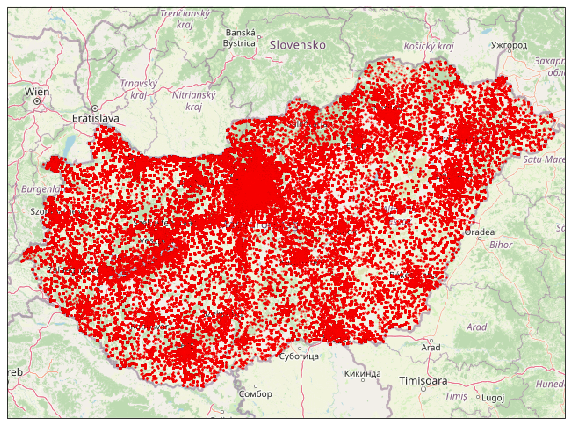

In [55]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), x=y_, y=x_)
plt.scatter( xynps[:,0], xynps[:,1], s=1, alpha=0.1, marker='o', color='red' )

### -- Load cleaned event file here --

### Investigate cleaned events

In [62]:
source+files_events_cleaned[100]

'/media/Data_storage/Mobilcell/Data/Events_20190311.csv.gz'

In [63]:
events_df_cleaned = pd.read_csv( source+files_events_cleaned[100], delimiter=';', 
                         header=None, names=["event_datetime", "equipment_identifier", 
                                 "network_identifier", "event_type", "event_direction", 
                                 "device_tac"])
events_df_cleaned.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [55]:
events_df_cleaned["tower_idx"] = [ tower_to_int[i] for i in events_df_cleaned.network_identifier.values ]
events_df_cleaned.head()

NameError: name 'events_df_cleaned' is not defined

In [59]:
points_to_plot = []
for i in tqdm( range(0, events_df_cleaned.shape[0], 25) ):
    points_to_plot.append( poligons_df.eov_idx.values[ np.searchsorted(poligons_df.tower_idx.values, events_df_cleaned.tower_idx.values[i]) ] )

100%|██████████| 2957701/2957701 [01:01<00:00, 48171.27it/s]


In [60]:
x_, y_ = transformer.transform( xx=raster_coords[ points_to_plot ][:,1], yy=raster_coords[ points_to_plot ][:,0]  )
x_.shape, y_.shape

((2957701,), (2957701,))

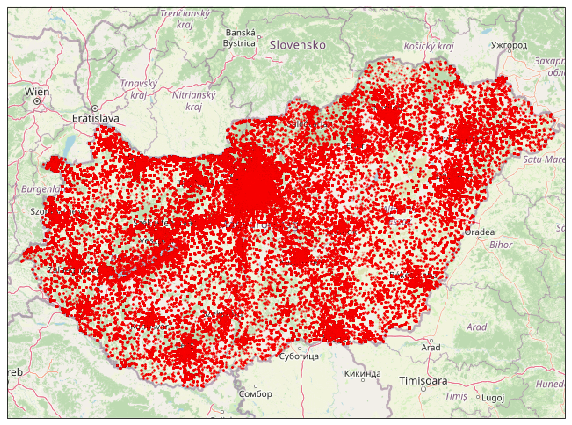

In [61]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), x=y_, y=x_)
plt.scatter( xynps[:,0], xynps[:,1], s=1, alpha=0.1, marker='o', color='red' )

### -- Skip until here --

### Lets see which towers are the most active ones

In [73]:
event_df_groups = events_df.groupby('tower_idx').groups
towers_id = np.array( list( event_df_groups.keys() ) )
towers_eq_num = np.array( [ len(i) for i in event_df_groups.values() ] )

#### Distribution of the number of events associated to a tower

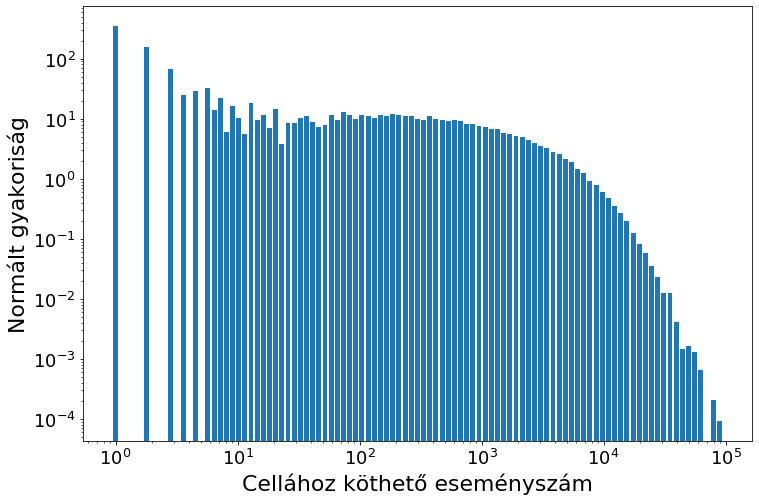

In [87]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(12,8) )
bins = np.logspace(0, 5, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram( towers_eq_num, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, 0.75*widths)
#plt.vlines( 3500, 1e0, 2e3, color='r', linestyles='--' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Cellához köthető eseményszám', fontsize=22)
plt.ylabel('Normált gyakoriság', fontsize=22)

plt.tick_params( labelsize=18 )
plt.savefig('cella_eseményszám.png', dpi=100)

In [76]:
towers_eq_num.mean()

4122.21109280615

#### Conclusion: on average a tower handles around 4000 events a day

In [77]:
sort_idx = np.argsort( towers_eq_num )
towers_id_actives = towers_id[ sort_idx ][-10000:]
towers_id_actives[:3]

array([21414,  7543, 39360])

100%|██████████| 10000/10000 [00:00<00:00, 66152.46it/s]


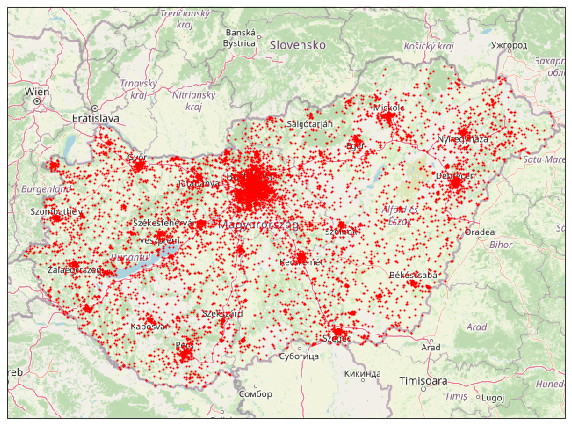

In [62]:
points_to_plot = []
for i in tqdm( range(towers_id_actives.shape[0]) ):
    points_to_plot.append( poligons_df.eov_idx.values[ np.searchsorted(poligons_df.tower_idx.values, towers_id_actives[i]) ] )

x_, y_ = transformer.transform( xx=raster_coords[ points_to_plot ][:,1], yy=raster_coords[ points_to_plot ][:,0]  )

# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), x=y_, y=x_)
plt.scatter( xynps[:,0], xynps[:,1], s=1, marker='o', color='red' )

In [68]:
event_df_cleaned_groups = events_df_cleaned.groupby('tower_idx').groups
towers_id = np.array( list( event_df_cleaned_groups.keys() ) )
towers_eq_num = np.array( [ len(i) for i in event_df_cleaned_groups.values() ] )

#### After cleaning this distribution is shifted

Text(0, 0.5, 'Frequency normalized by bin width')

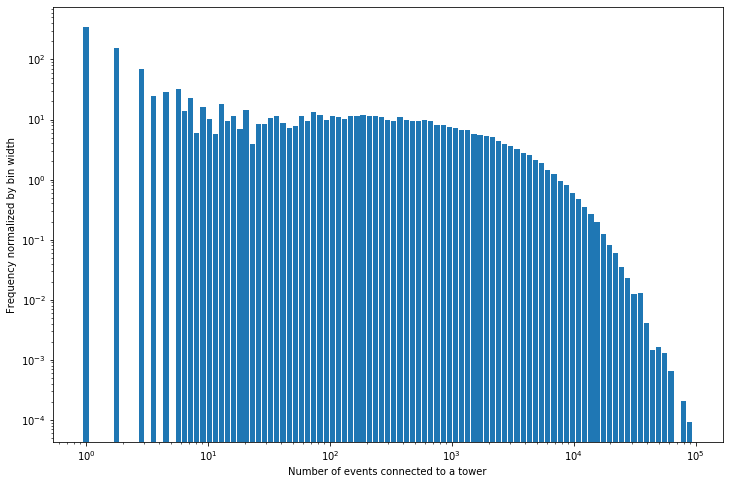

In [85]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(12,8) )
bins = np.logspace(0, 5, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram( towers_eq_num, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, 0.8*widths)
#plt.vlines( 3500, 1e0, 2e3, color='r', linestyles='--' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of events connected to a tower')
plt.ylabel('Frequency normalized by bin width')

##### A tower with more connections has more noisy data

### Investigation of events

In [79]:
events_df.shape, events_df_cleaned.shape

NameError: name 'events_df_cleaned' is not defined

In [80]:
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx
0,929,5C800002,22314009,V,O,216,35177706.0,10651
1,934,5C800002,22314009,V,O,216,35177706.0,10651
2,1142,5C800002,22314009,V,O,216,35177706.0,10651
3,1147,5C800002,22314009,V,O,216,35177706.0,10651
4,158,5C800003,325471968,D,O,216,35337609.0,39888


In [81]:
event_df_groups = events_df.groupby('equipment_identifier').groups
eq_id = np.array( list( event_df_groups.keys() ) )
eq_occurence_num = np.array( [ len(i) for i in event_df_groups.values() ] )

#### How many event is generated by an equipment

In [82]:
eq_occurence_num.min(), eq_occurence_num.max()

(1, 32093)

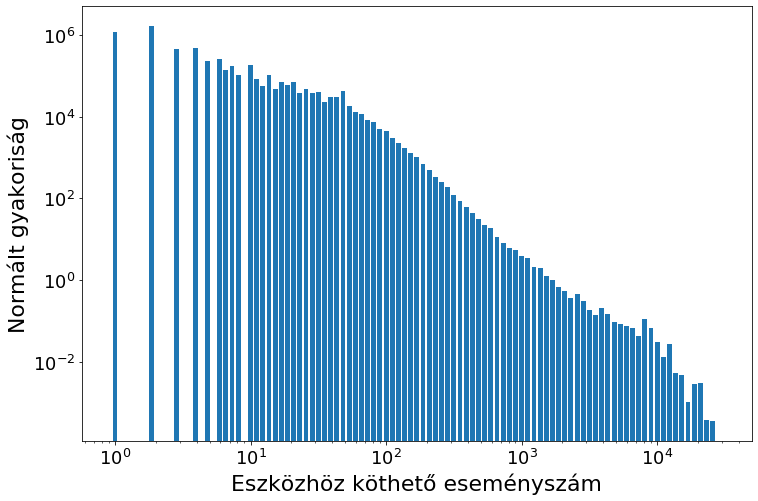

In [88]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(12,8) )
bins = np.logspace(0, 4.5, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(eq_occurence_num, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, 0.75*widths)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Eszközhöz köthető eseményszám', fontsize=22)
plt.ylabel('Normált gyakoriság', fontsize=22)

plt.tick_params( labelsize=18 )
plt.savefig('eszköz_eseményszám.png', dpi=100)

### Investigate poligon overlap on map

In [72]:
raster_overlap = np.zeros( raster_coords.shape[0], dtype=np.int32 )
np.add.at( raster_overlap, poligons_df.eov_idx.values, 1 )

#### Not every raster is covered by a tower -> outlier points that are abroad

In [73]:
np.unique(poligons_df.eov_idx).shape 

(5737349,)

In [74]:
raster_coords[:,1].shape, raster_coords[:,0].shape, raster_overlap.shape

((9913521,), (9913521,), (9913521,))

In [75]:
raster_coords[:3], raster_overlap[:3]

(array([[ 48262, 426468],
        [ 48262, 426595],
        [ 48262, 426722]], dtype=int32), array([0, 0, 0], dtype=int32))

In [76]:
x_, y_ = transformer.transform( xx=raster_coords[:,1], 
                                yy=raster_coords[:,0]  )

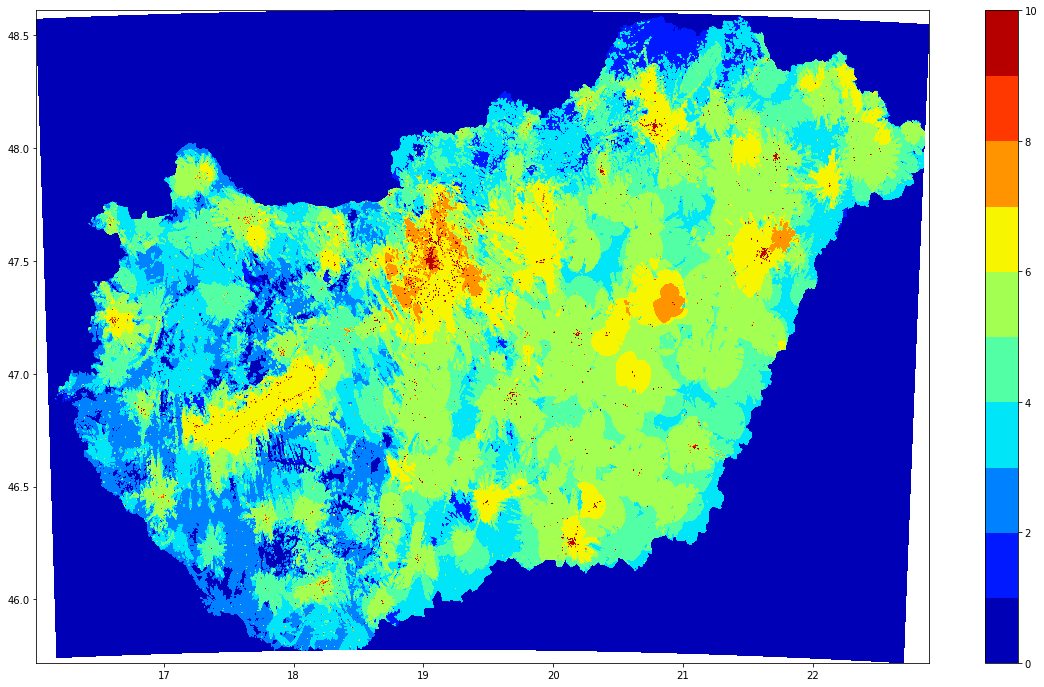

In [86]:
plt.figure( figsize=(20, 12) )
cmap = plt.contourf( y_.reshape( -1, (num_y+1) ), x_.reshape( -1, (num_y+1) ), 
                (raster_overlap).reshape( -1, (num_y+1) ), levels=np.arange(11),
                cmap='jet')
plt.colorbar(cmap)
plt.savefig( 'overlap_testfig.png', dpi=100)

### Investigation of equimnent trajectories

#### Coding events with unique integer

In [90]:
event_id = np.unique( events_df.equipment_identifier.values )
event_id[:5], event_id.shape

(array(['5C800002', '5C800003', '5C800004', '5C800005', '5C800006'],
       dtype=object), (4259594,))

In [92]:
event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))

#### Adding this encoding to the dataframe

In [94]:
events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx,event_idx
0,929,5C800002,22314009,V,O,216,35177706.0,10651,0
1,934,5C800002,22314009,V,O,216,35177706.0,10651,0
2,1142,5C800002,22314009,V,O,216,35177706.0,10651,0
3,1147,5C800002,22314009,V,O,216,35177706.0,10651,0
4,158,5C800003,325471968,D,O,216,35337609.0,39888,1


In [96]:
tower_id

array([    71892,     72307,     72922, ..., 553841622, 553841698,
       553841790])

#### In this case there are 4.2M individual events

In [108]:
eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
eq_diff_idx.shape

(4259593,)

In [116]:
%%time
events_df.tower_idx.values[ eq_diff_idx[0]:eq_diff_idx[1] ]

CPU times: user 49 µs, sys: 1e+03 ns, total: 50 µs
Wall time: 52.5 µs


array([39888,  8046, 12294,  4052,  4052,  4052, 39402, 42761, 42761,
        5912])

In [175]:
eq_trajectories_towers = []
eq_trajectories_time = []
for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
    start_ = eq_diff_idx[i]
    end_ = eq_diff_idx[i+1]
    eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
    eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )

100%|██████████| 4259592/4259592 [00:45<00:00, 94050.61it/s]


In [176]:
eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays
eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays
eq_trajectories_towers.shape, eq_trajectories_time.shape

((4259592,), (4259592,))

##### Get number of unique towers in trajectories, 1 means an eq that is still

In [177]:
eq_trajectories_towers_uq = np.array([ np.shape(np.unique(i))[0] for i in eq_trajectories_towers ])
eq_trajectories_towers_uq.shape, eq_trajectories_towers_uq[:3]

((4259592,), array([7, 1, 3]))

In [178]:
eq_trajectories_towers_uq[:10]

array([ 7,  1,  3,  1, 29,  6,  3,  3, 11,  1])

#### In this case there are around 3,4 M events that are moving to more towers

In [179]:
eq_trajectories_towers_uq[ eq_trajectories_towers_uq > 1 ].shape

(3383564,)

Text(0, 0.5, 'Frequency normalized')

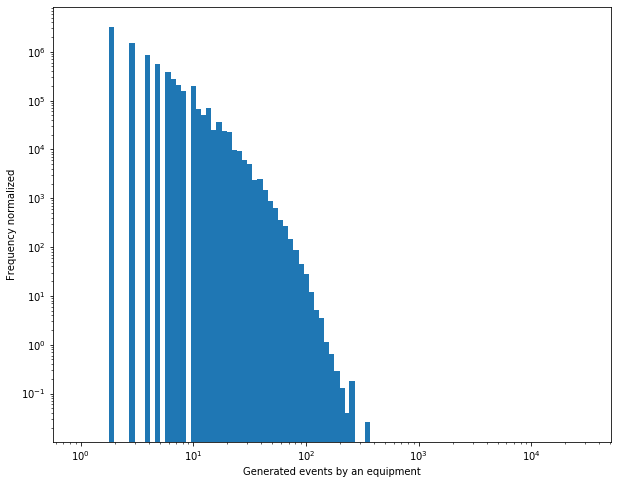

In [180]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(10,8) )
bins = np.logspace(0, 4.5, 100)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
hist = np.histogram(eq_trajectories_towers_uq[ eq_trajectories_towers_uq > 1], bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, widths)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Generated events by an equipment')
plt.ylabel('Frequency normalized')

#### Filter out resting events, then test if everything is correct

In [185]:
eq_trajectories_time = eq_trajectories_time[ eq_trajectories_towers_uq > 1 ]
eq_trajectories_towers = eq_trajectories_towers[ eq_trajectories_towers_uq > 1 ]

In [186]:
eq_trajectories_time.shape, eq_trajectories_towers.shape

((3383564,), (3383564,))

In [187]:
eq_trajectories_time[0], eq_trajectories_towers[0]

(array([ 158,  710,  718,  721,  721,  721, 1400, 1824, 1824, 1828]),
 array([39888,  8046, 12294,  4052,  4052,  4052, 39402, 42761, 42761,
         5912]))

In [181]:
events_df[ events_df.event_idx == 1 ]

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx,event_idx
4,158,5C800003,325471968,D,O,216,35337609.0,39888,1
5,710,5C800003,7846060,D,O,216,35337609.0,8046,1
6,718,5C800003,60444489,D,O,216,35337609.0,12294,1
7,721,5C800003,1638694,D,O,216,35337609.0,4052,1
8,721,5C800003,1638694,D,O,216,35337609.0,4052,1
9,721,5C800003,1638694,D,O,216,35337609.0,4052,1
10,1400,5C800003,315101460,S,I,216,35337609.0,39402,1
11,1824,5C800003,447063667,D,O,216,35337609.0,42761,1
12,1824,5C800003,447063667,V,O,216,35337609.0,42761,1
13,1828,5C800003,1915243,V,O,216,35337609.0,5912,1
